# Engineering Predictive Alpha Factors

This notebook illustrates the following steps:

1. Select the adjusted open, high, low, and close prices and the volume for all tickers for the 2006–2016 time period from the Quandl Wiki data that you downloaded and simplified in the last milestone. Looking ahead, we will use 2014–2016 as our “out-of-sample” period to test the performance of a strategy based on a machine learning model selected using data from preceding periods. We’re including some earlier years to ensure that all indicators (some of which are computed over longer windows) have data for the period of interest.

2. Compute the dollar volume as the product of closing price and trading volume, and then select 500 stocks with at least eight years of data and the highest average daily trading volume in dollar terms over the relevant period.

3. Compute daily returns and keep only inliers with values between -100% and +100% as a basic check against data error.

4. Now we’re ready to compute financial features. The Alpha Factory Library listed among the resources below illustrates how to compute a broad range of features using pandas and TA-Lib. We will list a few examples; feel free to explore and evaluate the various TA-Lib indicators.
    - Compute **historical returns** for various time ranges, such as 1, 3, 5, 10, and 21 trading days, as well as longer periods like 2, 3, 6, and 12 months.
    - Use TA-Lib’s **Bollinger Band** indicator to create features that anticipate **mean-reversion**.
    - Select some indicators from TA-Lib’s **momentum indicators** family, such as the following:
        - Average Directional Movement Index (ADX)
        - Moving Average Convergence Divergence (MACD)
        - Relative Strength Index (RSI)
        - Balance of Power (BOP)
        - Money Flow Index (MFI)
    - Compute TA-Lib **volume** indicators like On Balance Volume (OBV) or the Chaikin A/D Oscillator (ADOSC).
    - Create **volatility** metrics such as the Normalized Average True Range (NATR).
    - Compute **rolling factor betas** using the five Fama-French risk factors for different rolling windows of 3 and 12 months (see the statsmodels [“Rolling Regression”](https://www.statsmodels.org/dev/examples/notebooks/generated/rolling_ls.html) with examples of Fama-French data).
    - Compute the outcome variable that we will aim to predict, namely the **1-day forward returns**.

## Imports & Settings

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)
pd.options.display.float_format = '{:,.2f}'.format

## Load Data

In [9]:
DATA_STORE = Path('..', 'data', 'data.h5')

In [10]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['us_stocks'].unstack('ticker'))

prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 15995 entries, ('open', 'A') to ('volume', 'ZUMZ')
dtypes: float64(15995)
memory usage: 574.3 MB


In [11]:
prices

open                                                          ...  \
ticker         A    AA   AAL  AAMC   AAN  AAOI  AAON    AAP   AAPL   AAT  ...   
date                                                                      ...   
2000-01-03 53.73   NaN   NaN   NaN  5.12   NaN  1.12    NaN   3.37   NaN  ...   
2000-01-04 46.48   NaN   NaN   NaN  4.96   NaN  1.11    NaN   3.48   NaN  ...   
2000-01-05 45.20   NaN   NaN   NaN  4.96   NaN  1.09    NaN   3.33   NaN  ...   
2000-01-06 42.05   NaN   NaN   NaN  4.96   NaN  1.11    NaN   3.41   NaN  ...   
2000-01-07 40.29   NaN   NaN   NaN  4.96   NaN  1.07    NaN   3.10   NaN  ...   
...          ...   ...   ...   ...   ...   ...   ...    ...    ...   ...  ...   
2018-03-21 69.88 46.42 54.21 60.80 47.40 26.51 39.30 114.66 175.04 32.86  ...   
2018-03-22 68.70 47.40 53.58 59.95 46.85 26.50 38.90 114.02 170.00 32.39  ...   
2018-03-23 67.58 45.17 52.63 58.35 46.03 26.00 38.60 112.41 168.39 32.60  ...   
2018-03-26 67.20 45.26 51.94 58.60 45.93 25.55 37.85 112.49 168.07 32.03  ...   
2018-03-27 68.48 46.25 52.30 59.65 46.17 24.54 38.00 114.58 173.68 32.74  ...   

                 volume                                               \
ticker             ZIOP       ZIXI        ZLC ZLTQ ZMH          ZNGA   
date                                                                   
2000-01-03          NaN 555,200.00 291,700.00  NaN NaN           NaN   
2000-01-04          NaN 640,300.00 175,000.00  NaN NaN           NaN   
2000-01-05          NaN 439,900.00 325,800.00  NaN NaN           NaN   
2000-01-06          NaN 345,100.00 862,900.00  NaN NaN           NaN   
2000-01-07          NaN 373,700.00 389,300.00  NaN NaN           NaN   
...                 ...        ...        ...  ...  ..           ...   
2018-03-21   623,353.00 373,656.00        NaN  NaN NaN 17,590,899.00   
2018-03-22   750,150.00 242,336.00        NaN  NaN NaN 14,379,224.00   
2018-03-23   944,553.00 249,777.00        NaN  NaN NaN  9,850,955.00   
2018-03-26 1,093,052.00 189,327.00        NaN  NaN NaN  9,075,940.00   
2018-03-27   983,328.00 207,304.00        NaN  NaN NaN 11,026,010.00   

                                                          
ticker           ZOES        ZQK          ZTS       ZUMZ  
date                                                      
2000-01-03        NaN 124,900.00          NaN        NaN  
2000-01-04        NaN 201,700.00          NaN        NaN  
2000-01-05        NaN 161,700.00          NaN        NaN  
2000-01-06        NaN 120,600.00          NaN        NaN  
2000-01-07        NaN 163,400.00          NaN        NaN  
...               ...        ...          ...        ...  
2018-03-21 188,672.00        NaN 3,193,284.00 354,092.00  
2018-03-22 225,587.00        NaN 3,203,633.00 269,607.00  
2018-03-23 306,737.00        NaN 2,590,726.00 301,584.00  
2018-03-26 421,967.00        NaN 3,084,185.00 375,320.00  
2018-03-27 261,242.00        NaN 2,676,191.00 403,884.00  

[4706 rows x 15995 columns]

## 1. Select the adjusted open, high, low, and close prices and the volume for all tickers

Use the Quandl Wiki data that you downloaded and simplified for the last milestone for the 2006-2016 time period.

Looking ahead, we will use 2014–2016 as our “out-of-sample” period to test the performance of a strategy based on a machine learning model selected using data from preceding periods.


In [12]:
# Select data for 2006-2016 time period.

prices = prices.loc[idx['2006-01-01':'2016-12-31']]

In [13]:
# Put ticker back into the index after date (second level).

prices = prices.stack('ticker')

prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7532460 entries, (Timestamp('2006-01-02 00:00:00'), 'TAM') to (Timestamp('2016-12-30 00:00:00'), 'ZUMZ')
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   low     float64
 2   high    float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 316.3+ MB


In [14]:
prices.head()

open   low  high  close       volume
date       ticker                                      
2006-01-02 TAM     0.47  0.47  0.47   0.47    77,100.00
2006-01-03 A      22.79 22.39 22.91  22.86 3,796,200.00
           AAL    96.66 95.75 99.46  97.31 2,716,354.00
           AAN    12.37 12.37 12.69  12.69     2,067.00
           AAON    3.08  3.02  3.11   3.11     5,452.00

## 2a. Compute the dollar volume


In [15]:
# Compute the dollar volume as the product of the adjusted close price and the adjusted volume.

prices['dollar_volume'] = prices['close']*prices['volume']

prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7532460 entries, (Timestamp('2006-01-02 00:00:00'), 'TAM') to (Timestamp('2016-12-30 00:00:00'), 'ZUMZ')
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   open           float64
 1   low            float64
 2   high           float64
 3   close          float64
 4   volume         float64
 5   dollar_volume  float64
dtypes: float64(6)
memory usage: 373.8+ MB


## 2b. Select 500 most-traded stocks meeting our criteria

Select the stocks with:

- At least eight years of data.
- Highest average daily rank for this metric; i.e., highest average dollar volume.

In [16]:
# Get a list of stocks that have at least eight years of data.

number_of_trading_days = 8 * 252

have_8yrs_data = prices.groupby(['ticker']).size() > number_of_trading_days

In [17]:
# Get the data for the stocks with at least eight years of data.

data_8yrs = (prices
               .unstack('date')
               .loc[have_8yrs_data]
               .stack('date')
               .swaplevel()
            )

data_8yrs.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6785663 entries, (Timestamp('2006-01-02 00:00:00'), 'TAM') to (Timestamp('2016-12-30 00:00:00'), 'CLW')
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   open           float64
 1   low            float64
 2   high           float64
 3   close          float64
 4   volume         float64
 5   dollar_volume  float64
dtypes: float64(6)
memory usage: 336.7+ MB


In [18]:
data_8yrs

,,open,low,high,close,volume,dollar_volume
date,ticker,,,,,,
2006-01-02,TAM,0.47,0.47,0.47,0.47,"77,100.00","36,237.00"
2006-01-03,TAM,0.47,0.47,0.47,0.47,"396,900.00","184,558.50"
2006-01-04,TAM,0.47,0.47,0.47,0.47,"110,200.00","51,243.00"
2006-01-05,TAM,0.47,0.47,0.47,0.47,0.00,0.00
2006-01-06,TAM,0.47,0.47,0.47,0.47,0.00,0.00
...,...,...,...,...,...,...,...
2016-12-23,CLW,66.70,66.20,67.60,67.35,"29,526.00","1,988,576.10"
2016-12-27,CLW,67.20,67.20,68.28,67.40,"36,805.00","2,480,657.00"
2016-12-28,CLW,67.60,65.90,68.40,66.20,"47,912.00","3,171,774.40"


In [19]:
# Compute average dollar_volume and sort from high to low.

ave_dollar_volume = (data_8yrs['dollar_volume'].groupby('ticker')
                                               .mean()
                                               .sort_values(ascending=False)
                    )

In [20]:
# Get a list of the top 500 stocks based on average daily dollar volume.

top_ave_dollar_volume = ave_dollar_volume[:500]
top_ave_dollar_volume

ticker
YRCW    87,654,360,587.48
LVLT     9,562,230,654.27
C        8,910,502,588.21
BAS      7,050,187,395.30
BRK_A    5,901,194,914.45
               ...       
DCT         60,643,929.60
LINTA       60,560,265.03
VIAS        60,402,554.55
UPIP        60,273,643.33
RAI         60,060,198.00
Name: dollar_volume, Length: 500, dtype: float64

In [21]:
# Get the data for the top 500 stocks.
top500 = data_8yrs.loc[(slice(None), top_ave_dollar_volume.index), :]

top500.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1364135 entries, (Timestamp('2006-01-03 00:00:00'), 'YRCW') to (Timestamp('2016-12-30 00:00:00'), 'RAI')
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           1364135 non-null  float64
 1   low            1364134 non-null  float64
 2   high           1364134 non-null  float64
 3   close          1364135 non-null  float64
 4   volume         1364135 non-null  float64
 5   dollar_volume  1364135 non-null  float64
dtypes: float64(6)
memory usage: 67.8+ MB


In [22]:
top500

,,open,low,high,close,volume,dollar_volume
date,ticker,,,,,,
2006-01-03,YRCW,"326,175.00","322,575.00","335,700.00","334,500.00","750,000.00","250,875,000,000.00"
2006-01-04,YRCW,"338,775.00","337,125.00","353,550.00","350,025.00","750,000.00","262,518,750,000.00"
2006-01-05,YRCW,"348,450.00","344,250.00","348,975.00","348,525.00","750,000.00","261,393,750,000.00"
2006-01-06,YRCW,"351,375.00","347,325.00","354,600.00","351,525.00","750,000.00","263,643,750,000.00"
2006-01-09,YRCW,"356,850.00","352,950.00","357,600.00","356,175.00",0.00,0.00
...,...,...,...,...,...,...,...
2016-12-23,RAI,55.01,54.88,55.18,55.14,"2,917,151.00","160,846,755.71"
2016-12-27,RAI,55.14,55.04,55.39,55.29,"3,068,195.00","169,627,970.41"
2016-12-28,RAI,55.13,54.90,55.26,55.05,"3,705,933.00","204,010,630.72"


## 3. Compute daily returns and remove outliers based on daily returns

Keep only 'inliers' with values between -100% and + 100% as a basic check against data error.

In [23]:
# Compute the daily return and add it to the top500 dataframe.

top500['ret'] = top500.groupby('ticker').close.pct_change()
top500.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1364135 entries, (Timestamp('2006-01-03 00:00:00'), 'YRCW') to (Timestamp('2016-12-30 00:00:00'), 'RAI')
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           1364135 non-null  float64
 1   low            1364134 non-null  float64
 2   high           1364134 non-null  float64
 3   close          1364135 non-null  float64
 4   volume         1364135 non-null  float64
 5   dollar_volume  1364135 non-null  float64
 6   ret            1363635 non-null  float64
dtypes: float64(7)
memory usage: 78.2+ MB


We only want stocks with a daily return percentage between -100% and +100%. 

This should provide a basic check against data error.

In [24]:
# Get the daily returns.

returns = top500['ret']
returns.describe()

count   1,363,635.00
mean            0.00
std             0.03
min            -0.86
25%            -0.01
50%             0.00
75%             0.01
max             2.42
Name: ret, dtype: float64

In [25]:
# Drop the NaN records.

adj_returns = returns.dropna()
adj_returns.info()

<class 'pandas.core.series.Series'>
MultiIndex: 1363635 entries, (Timestamp('2006-01-04 00:00:00'), 'YRCW') to (Timestamp('2016-12-30 00:00:00'), 'RAI')
Series name: ret
Non-Null Count    Dtype  
--------------    -----  
1363635 non-null  float64
dtypes: float64(1)
memory usage: 15.8+ MB


In [26]:
# Look for records with returns between 1.0 (100%) and -1.0 (-100%)
# and adjust for the records with ret == NaN

inliers = returns.dropna().between(-1,1)
inliers.info()

<class 'pandas.core.series.Series'>
MultiIndex: 1363635 entries, (Timestamp('2006-01-04 00:00:00'), 'YRCW') to (Timestamp('2016-12-30 00:00:00'), 'RAI')
Series name: ret
Non-Null Count    Dtype
--------------    -----
1363635 non-null  bool 
dtypes: bool(1)
memory usage: 6.7+ MB


In [27]:
# Find the outliers; i.e., records with returns outside of the desired range.

outliers = adj_returns[~inliers].unstack('date').index
outliers

Index(['CTIC', 'HIG', 'STSA', 'AXLL', 'FMD', 'GGP', 'TEAR', 'DNDN'], dtype='object', name='ticker')

In [28]:
# Drop the outliers.

final500 = top500.drop(top500.loc[(slice(None), outliers),:].index)
final500.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1343376 entries, (Timestamp('2006-01-03 00:00:00'), 'YRCW') to (Timestamp('2016-12-30 00:00:00'), 'RAI')
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           1343376 non-null  float64
 1   low            1343375 non-null  float64
 2   high           1343375 non-null  float64
 3   close          1343376 non-null  float64
 4   volume         1343376 non-null  float64
 5   dollar_volume  1343376 non-null  float64
 6   ret            1342884 non-null  float64
dtypes: float64(7)
memory usage: 77.0+ MB


In [29]:
# Verify that we have only records with daily returns within the
# desired range.

final500['ret'].describe()

count   1,342,884.00
mean            0.00
std             0.03
min            -0.86
25%            -0.01
50%             0.00
75%             0.01
max             0.98
Name: ret, dtype: float64

In [30]:
# How many stocks remain? 492

final500_stocks = final500.unstack('date').index.unique()
final500_stocks

Index(['YRCW', 'LVLT', 'C', 'BAS', 'BRK_A', 'AIG', 'KEG', 'BTU', 'GOOGL',
       'AAPL',
       ...
       'VAR', 'NDAQ', 'RAD', 'AEO', 'AGCO', 'DCT', 'LINTA', 'VIAS', 'UPIP',
       'RAI'],
      dtype='object', name='ticker', length=492)

### Helper functions for computing the indicators

These functions will help make the code for computing the indicators a little easier to write and understand. They are common steps we'll perform for each indicator.

We'll use a working dataframe with the date as the index and columns like this:

```
           ticker  open   low  high close    volume  dollar_volume    ret
date								
2012-01-03   YRCW  7.94  7.94  9.7   8.98 117,100.00  1,051,558.00  -0.10
2012-01-04   YRCW  8.98  8.87  9.48  9.30  78,600.00    730,980.00   0.04
```

In [31]:
# Return the computed indicator data from a given dataframe.
# The dataframe should have date as the index with ticker and other columns.
# The compute_ind function should extract the data for a given symbol from the dataframe.

def all_ind_data(df, compute_ind):
    ind_df = pd.DataFrame()
    # FIXME: Can we use groupby() to speed things up?
    for symbol in df.ticker.unique():
        ind_df = pd.concat([ind_df, compute_ind(df, symbol)])
    return ind_df

In [32]:
# Get the indicator data for the symbol from a given dataframe.
# The dataframe should have date as the index with ticker and other columns.
# The columns are the data for a specific indicator.

def get_data_for(df, symbol, cols):
    return df[df.ticker == symbol][['ticker','close'] + cols]

### Data to use to compute the indicators


In [33]:
# Reshape the final500 dataframe to use to compute the indicators.

f2 = final500.reset_index(level=1)

## 4. Compute financial features

- Compute **historical returns** for various time ranges such as 1, 3, 5, 10, 21 trading days, as well as longer periods like 2, 3, 6 and 12 months.
- Use TA-Lib's **Bollinger Band** indicator to create features that anticipate **mean-reversion**.
- Select some indicators from TA-Lib's **momentum** indicators family such as
   - the Average Directional Movement Index (ADX), 
   - the Moving Average Convergence Divergence (MACD), 
   - the Relative Strength Index (RSI), 
   - the Balance of Power (BOP) indictor, or 
   - the Money Flow Index (MFI).
- Compute TA-Lib **volume** indicators like On Balance Volume (OBV) or the Chaikin A/D Oscillator (ADOSC)
- Create volatility metrics such as the Normalized Average True Range (NATR).
- Compute rolling factor betas using the five Fama-French risk factors for different rolling windows of three and 12 months (see resources below).
- Compute the outcome variable that we will aim to predict, namely the 1-day forward returns.

## 4a. Historical Returns

Compute **historical returns** for various time ranges such as 1, 3, 5, 10, and 21 trading days.


Refer to:
   - *How to compute returns for multiple historical periods* in the PDF of Chapter 4, "Financial Feature Engineering - How to research Alpha Factors" in *ML for Algorithmic Trading"
   - `01_feature_engineering.ipynb` notebook in the `04_alpha_factor_research` directory of the https://github.com/stefan-jansen/machine-learning-for-trading repo.

From *How to compute returns for multiple historical periods*:

> To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using `.pct_change(n_periods)` to get returns over various periods.
>
> We then convert the wide result back to long format with the .stack() method, use .pipe() to apply the .clip() method to the resulting DataFrame, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.
>
> Finally, we normalize returns using the geometric average. After using .swaplevel() to change the order of the MultiIndex levels, we obtain compounded returns for the desired periods.

In [34]:
# We'll use the daily closing prices to compute historical daily returns.

daily_prices = final500['close'].unstack('ticker')

In [35]:
# Compute historical returns from daily closing prices.

historical_daily_returns = pd.DataFrame()
outlier_cutoff = 0.01
# The lags are the different periods or number of previous days.
lags = [1, 3, 5, 10, 21]

for lag in lags:
    historical_daily_returns[f'return_{lag}d'] = (
        daily_prices
          .pct_change(lag)
          .stack()
          .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                 upper=x.quantile(1-outlier_cutoff)))
          .add(1)
          .pow(1/lag)
          .sub(1)
        )
    
historical_daily_returns = historical_daily_returns.swaplevel().dropna()

historical_daily_returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1343141 entries, ('YRCW', Timestamp('2006-02-02 00:00:00')) to ('RAI', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   return_1d   1343141 non-null  float64
 1   return_3d   1343141 non-null  float64
 2   return_5d   1343141 non-null  float64
 3   return_10d  1343141 non-null  float64
 4   return_21d  1343141 non-null  float64
dtypes: float64(5)
memory usage: 56.5+ MB


In [36]:
# The number of stocks in the final500. Should be 492 after removing outliers.

historical_daily_returns.index.get_level_values('ticker').nunique()

492

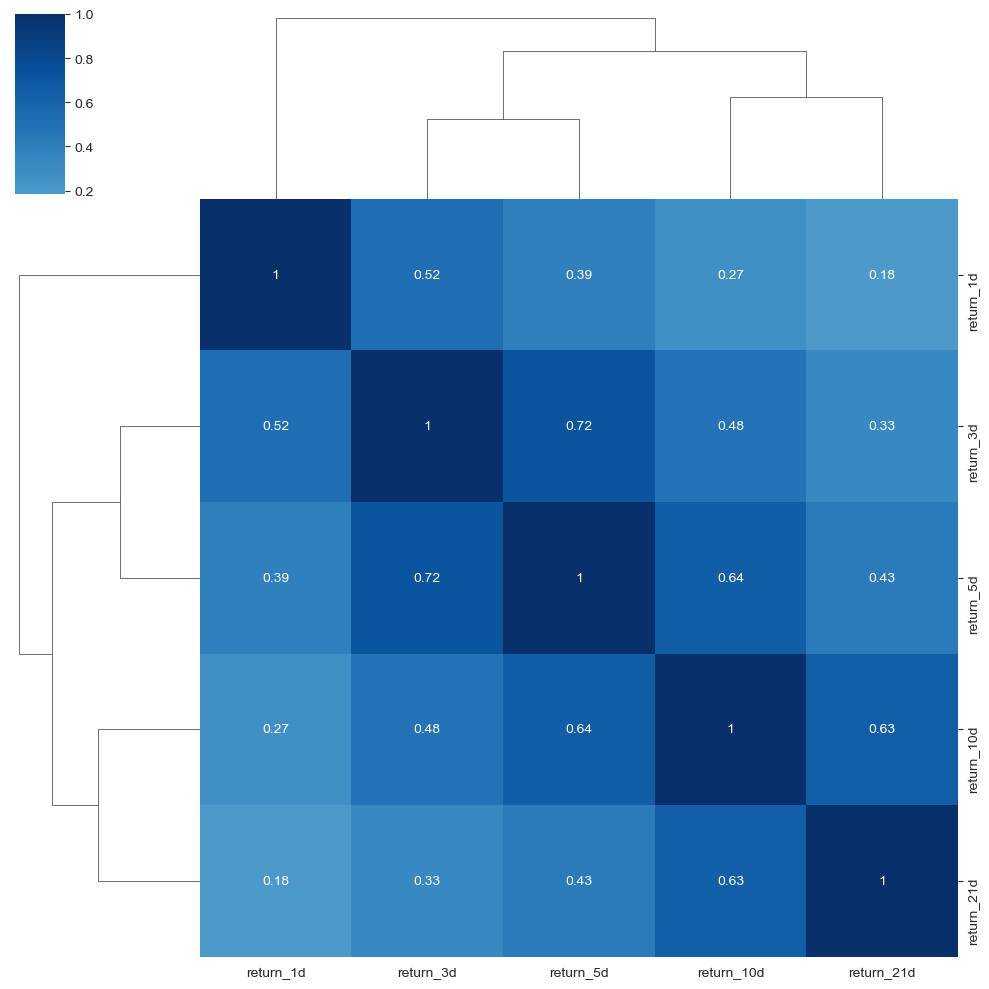

In [37]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(historical_daily_returns.corr('spearman'), annot=True, center=0, cmap='Blues');

## 4b. Bollinger Bands

Use TA-Lib's **Bollinger Band** indicator to create features that anticipate **mean-reversion**.

Refer to:
  - "Compute Bollinger Bands" section in the `02_how_to_use_talib.ipynb` notebook in the 
`04_alpha_factor_research` directory of the https://github.com/stefan-jansen/machine-learning-for-trading repo.
  

For the BBANDS function in TA-Lib, see https://github.com/mrjbq7/ta-lib/blob/master/docs/func_groups/overlap_studies.md.


In [38]:
def compute_bb(df, symbol):
    # Get the data for a specific symbol; df is indexed on date
    sd = df.loc[df.ticker == symbol, ['ticker','close']]
    up, mid, low = talib.BBANDS(sd.close, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)
    sd['bb_up'] = up
    sd['bb_mid'] = mid
    sd['bb_low'] = low
    return sd

In [39]:
bb_all = all_ind_data(f2, compute_bb)

## 4c. Momentum Indicators

Compute these indicators using TA-Lib's momentum indicators:
- ADX
- MACD
- RSI
- BOP
- MFI

### 4c-i. Average Directional Movement Index (ADX)

The ADX combines of two other indicators, namely the positive and directional indicators (PLUS_DI and MINUS_DI), which in turn build on the positive and directional movement (PLUS_DM and MINUS_DM). For additional details see [Wikipedia](https://en.wikipedia.org/wiki/Average_directional_movement_index) and [Investopedia](https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp).

From [Wikipedia](https://en.wikipedia.org/wiki/Average_directional_movement_index):

>The ADX does not indicate trend direction or momentum, only trend strength.
>It is a lagging indicator; that is, a trend must have established itself before the ADX will generate a signal that a trend is under way.
>
>ADX will range between 0 and 100.
>
>Generally, ADX readings below 20 indicate trend weakness, and readings above 40 indicate trend strength. An extremely strong trend is indicated by readings above 50.

For the ADX function in TA-Lib, see https://github.com/mrjbq7/ta-lib/blob/master/docs/func_groups/momentum_indicators.md.

In [40]:
def compute_adx(df, symbol):
    # Get the data for a specific symbol; df is indexed on date
    sd = df.loc[df.ticker == symbol, ['ticker','high','low','close']]
    # Compute the indicator
    # From Wikipedia, the creator of ADX used a timeout period of 14 days.
    adx = talib.ADX(sd.high, sd.low, sd.close, timeperiod=14)
    sd = df.loc[df.ticker == symbol, ['ticker','close']]
    sd['adx'] = adx
    return sd

In [41]:
adx_all = all_ind_data(f2, compute_adx)

### 4c-ii. Moving Average Convergence/Divergence (MACD)

Moving Average Convergence Divergence (MACD) is a trend-following (lagging) momentum indicator that shows the relationship between two moving averages of a security’s price. It is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

The TA-Lib implementation returns the MACD value and its signal line, which is the 9-day EMA of the MACD. In addition, the MACD-Histogram measures the distance between the indicator and its signal line.

Refer to:

"Moving Average Convergence/Divergence" section in the 02_how_to_use_talib.ipynb notebook in the 04_alpha_factor_research directory of the https://github.com/stefan-jansen/machine-learning-for-trading repo.

For the MACD function in TA-Lib, see https://github.com/mrjbq7/ta-lib/blob/master/docs/func_groups/momentum_indicators.md.


In [42]:
def compute_macd(df, symbol):
    # Get the data for a specific symbol; df is indexed on date
    sd = df.loc[df.ticker == symbol, ['ticker','close']]
    
    macd, macdsignal, macdhist = talib.MACD(sd.close, fastperiod=12, slowperiod=26, signalperiod=9)
    
    sd['macd'] = macd
    sd['macdsignal'] = macdsignal
    sd['macdhist'] = macdhist
    return sd

In [43]:
macd_all = all_ind_data(f2, compute_macd)

### 4c-iii. Relative Strength Index (RSI)

RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold. A high RSI (usually above 70) indicates overbought and a low RSI (typically below 30) indicates oversold. It first computes the average price change for a given number (often 14) of prior trading days with rising and falling prices, respectively as $\text{up}_t$ and $\text{down}_t$. Then, the RSI is computed as:
$$
\text{RSI}_t=100-\frac{100}{1+\frac{\text{up}_t}{\text{down}_t}}
$$



Refer to:

"Compute Relative Strength Index" section in the 02_how_to_use_talib.ipynb notebook in the 04_alpha_factor_research directory of the https://github.com/stefan-jansen/machine-learning-for-trading repo.

For the RSI function in TA-Lib, see https://github.com/mrjbq7/ta-lib/blob/master/docs/func_groups/momentum_indicators.md.


In [44]:
def compute_rsi(df, symbol):
    # Get the data for a specific symbol; df is indexed on date
    sd = df.loc[df.ticker == symbol, ['ticker','close']]
    rsi = talib.RSI(sd.close, timeperiod=14)
    sd['rsi'] = rsi
    return sd

In [45]:
rsi_all = all_ind_data(f2, compute_rsi)

### 4c-iv. Balance Of Power (BOP)

The Balance of Power (BOP) intends to measure the strength of buyers relative to sellers in the market by assessing the ability of each side to drive prices. It is computer as the difference between the close and the open price, divided by the difference between the high and the low price: 

$$
\text{BOP}_t= \frac{P_t^\text{Close}-P_t^\text{Open}}{P_t^\text{High}-P_t^\text{Low}}
$$

For the BOP function in TA-Lib, see https://github.com/mrjbq7/ta-lib/blob/master/docs/func_groups/momentum_indicators.md.


In [46]:
def compute_bop(df, symbol):
    # Get the data for a specific symbol; df is indexed on date
    sd = df.loc[df.ticker == symbol, ['ticker','open','high','low','close']]
    # Compute the indicator
    bop = talib.BOP(sd.open, sd.high, sd.low, sd.close)
    sd = df.loc[df.ticker == symbol, ['ticker','close']]
    sd['bop'] = bop
    return sd

In [47]:
bop_all = all_ind_data(f2, compute_bop)

### 4c-v. Money Flow Index (MFI)

The Money Flow Index (MFI) incorporates price and volume information to identify overbought or oversold conditions.  The indicator is typically calculated using 14 periods of data. An MFI reading above 80 is considered overbought and an MFI reading below 20 is considered oversold.

For the MFI function in TA-Lib, see https://github.com/mrjbq7/ta-lib/blob/master/docs/func_groups/momentum_indicators.md.


In [48]:
def compute_mfi(df, symbol):
    # Get the data for a specific symbol; df is indexed on date
    sd = df.loc[df.ticker == symbol, ['ticker','high','low','close','volume']]
    # Compute the indicator
    mfi = talib.MFI(sd.high, sd.low, sd.close, sd.volume, timeperiod=14)
    sd = df.loc[df.ticker == symbol, ['ticker','close']]
    sd['mfi'] = mfi
    return sd

In [49]:
mfi_all = all_ind_data(f2, compute_mfi)

## 4d. Volume Indicators

Compute TA-Lib volume indicators like On Balance Volume (OBV) or the Chaikin A/D Oscillator (ADOSC).

|Function|             Name|
|:---|:---|
|AD|                   Chaikin A/D Line|
|ADOSC|                Chaikin A/D Oscillator|
|OBV|                  On Balance Volume|

### Chaikin A/D Line

The Chaikin Advance/Decline or Accumulation/Distribution Line (AD) is a volume-based indicator designed to measure the cumulative flow of money into and out of an asset. The indicator assumes that the degree of buying or selling pressure can be determined by the location of the close, relative to the high and low for the period. There is buying (sellng) pressure when a stock closes in the upper (lower) half of a period's range. The intention is to signal a change in direction when the indicator diverges from the security price.

The Accumulation/Distribution Line is a running total of each period's Money Flow Volume. It is calculated as follows:

1. The Money Flow Multiplier (MFI) is the relationship of the close to the high-low range:
2. The MFI is multiplied by the period's volume $V_t$ to come up with a Money Flow Volume (MFV). 
3. A running total of the Money Flow Volume forms the Accumulation Distribution Line:
$$
\begin{align*}
&\text{MFI}_t&=\frac{P_t^\text{Close}-P_t^\text{Low}}{P_t^\text{High}-P_t^\text{Low}}\\
&\text{MFV}_t&=\text{MFI}_t \times V_t\\
&\text{AD}_t&=\text{AD}_{t-1}+\text{MFV}_t
\end{align*}
$$

For the AD function in the TA-Lib, see https://github.com/mrjbq7/ta-lib/blob/master/docs/func_groups/volume_indicators.md.

In [50]:
def compute_ad(df, symbol):
    # Get the data for a specific symbol; df is indexed on date
    sd = df.loc[df.ticker == symbol, ['ticker','high','low','close','volume']]
    # Compute the indicator
    ad = talib.AD(sd.high, sd.low, sd.close, sd.volume)
    sd = df.loc[df.ticker == symbol, ['ticker','close']]
    sd['ad'] = ad
    return sd

In [51]:
ad_all = all_ind_data(f2, compute_ad)

### Chaikin A/D Oscillator (ADOSC)

The Chaikin A/D Oscillator (ADOSC) is the Moving Average Convergence Divergence indicator (MACD) applied to the Chaikin A/D Line. The Chaikin Oscillator intends to predict changes in the Accumulation/Distribution Line.

It is computed as the difference between the 3-day exponential moving average and the 10-day exponential moving average of the Accumulation/Distribution Line.

For the ADOSC function in the TA-Lib, see https://github.com/mrjbq7/ta-lib/blob/master/docs/func_groups/volume_indicators.md.

In [52]:
def compute_adosc(df, symbol):
    # Get the data for a specific symbol; df is indexed on date
    sd = df.loc[df.ticker == symbol, ['ticker','high','low','close','volume']]
    # Compute the indicator
    adosc = talib.ADOSC(sd.high, sd.low, sd.close, sd.volume, fastperiod=3, slowperiod=10)
    sd = df.loc[df.ticker == symbol, ['ticker','close']]
    sd['adosc'] = adosc
    return sd

In [53]:
adosc_all = all_ind_data(f2, compute_adosc)

### On Balance Volume (OBV)

The On Balance Volume indicator (OBV) is a cumulative momentum indicator that relates volume to price change. It assumes that OBV changes precede price changes because smart money can be seen flowing into the security by a rising OBV. When the public then moves into the security, both the security and OBV will rise.

The current OBV is computed by adding (subtracting) the current volume to the last OBV if the security closes higher (lower) than the previous close.

$$
\text{OBV}_t = 
\begin{cases}
\text{OBV}_{t-1}+V_t & \text{if }P_t>P_{t-1}\\
\text{OBV}_{t-1}-V_t & \text{if }P_t<P_{t-1}\\
\text{OBV}_{t-1} & \text{otherwise}
\end{cases}
$$

For the OBV function in the TA-Lib, see https://github.com/mrjbq7/ta-lib/blob/master/docs/func_groups/volume_indicators.md.

In [54]:
def compute_obv(df, symbol):
    # Get the data for a specific symbol; df is indexed on date
    sd = df.loc[df.ticker == symbol, ['ticker','close','volume']]
    # Compute the indicator
    obv = talib.OBV(sd.close, sd.volume)
    sd = df.loc[df.ticker == symbol, ['ticker','close']]
    sd['obv'] = obv
    return sd

In [55]:
obv_all = all_ind_data(f2, compute_obv)

## 4e. Volatility Indicators


Create volatility metrics such as the Normalized Average True Range (NATR).

### NATR

The Normalized Average True Range (NATR) is a normalized version of the ATR computed as follows:

$$
\text{NATR}_t = \frac{\text{ATR}_t(T)}{P_t^\text{Close}} * 100
$$

Normalization make the ATR function more relevant in the folllowing scenarios:
- Long term analysis where the price changes drastically.
- Cross-market or cross-security ATR comparison.

For the NATR function in the TA-Lib, see https://github.com/mrjbq7/ta-lib/blob/master/docs/func_groups/volatility_indicators.md.

In [56]:
def compute_natr(df, symbol):
    # Get the data for a specific symbol; df is indexed on date
    sd = df.loc[df.ticker == symbol, ['ticker','high','low','close']]
    # Compute the indicator
    natr = talib.NATR(sd.high, sd.low, sd.close, timeperiod=14)
    sd = df.loc[df.ticker == symbol, ['ticker','close']]
    sd['natr'] = natr
    return sd

In [57]:
natr_all = all_ind_data(f2, compute_natr)

## 4f. Rolling Factor Betas

Compute rolling factor betas using the five Fama-French risk factors for different rolling windows of three and 12 months.

Refer to:
  - The "Rolling Factor Betas" section of the `01_feature_engineering.ipynb` notebook in the `04_alpha_factor_research` directory of the https://github.com/stefan-jansen/machine-learning-for-trading repo.


See also:
  - "How to measure asset quality" (p. 93) and "Computing factor betas" (p. 97) sections in *Machine Learning for Algorithmic Trading, 2nd. Edition*.
  - "Computing factor betas" on p. 97 in the "Computing factor betas" section in *Machine Learning for Algorithmic Trading, 2nd. Edition*.
  - "Get Data" section in the `02_fama_macbeth.ipynb` notebook in the 
`07_linear_models` directory of the https://github.com/stefan-jansen/machine-learning-for-trading repo.
  - [Rolling Regression OLS](https://www.statsmodels.org/dev/examples/notebooks/generated/rolling_ls.html) module in the statsmodels package.



From the Discussions chat:

> Claudiu Schiller: As we’re using for this section the 1-day forward return as a prediction target using the daily returns and factors is appropriate for calculating the betas. The book shows an example for monthly returns. It’s not mandatory to match periods, you could argue daily calculations give you more statistically robust results.

In [58]:
# The Fama-French 5 factors from Ken French's website.
# The data is monthly.

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3',
                             'famafrench', start='2000')[0]
                  .drop('RF', axis=1))

In [59]:
# Change the index values to timestamps.

factor_data.index = factor_data.index.to_timestamp()

factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2000-01-01,-4.74,4.44,-1.91,-6.31,4.75
2000-02-01,2.45,18.34,-9.70,-18.73,-0.36
2000-03-01,5.20,-15.35,8.17,11.82,-1.65
2000-04-01,-6.40,-5.01,7.26,7.66,5.65
2000-05-01,-4.42,-3.84,4.81,4.17,1.30
...,...,...,...,...,...
2022-06-01,-8.43,1.30,-5.97,1.85,-4.70
2022-07-01,9.57,1.88,-4.10,0.68,-6.94
2022-08-01,-3.77,1.51,0.31,-4.79,1.30


In [60]:
# Upsample from monthly to business days
# We'll use the monthly factor for all of the days in a month.

daily_factor_data = (factor_data
                      .resample('B')
                      .ffill().loc[historical_daily_returns
                                   .swaplevel()
                                   .reset_index(level=1)
                                   .index.unique()
                                   #.astype('str')
                                  ]
                    )

daily_factor_data.index.name = 'date'
daily_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2748 entries, 2006-02-02 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  2748 non-null   float64
 1   SMB     2748 non-null   float64
 2   HML     2748 non-null   float64
 3   RMW     2748 non-null   float64
 4   CMA     2748 non-null   float64
dtypes: float64(5)
memory usage: 128.8 KB


In [61]:
# Add the historical 1-day returns to the daily factor data.

daily_factor_data = daily_factor_data.join(historical_daily_returns['return_1d']).sort_index()
daily_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1343141 entries, ('A', Timestamp('2006-02-02 00:00:00')) to ('ZMH', Timestamp('2016-12-30 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Mkt-RF     1343141 non-null  float64
 1   SMB        1343141 non-null  float64
 2   HML        1343141 non-null  float64
 3   RMW        1343141 non-null  float64
 4   CMA        1343141 non-null  float64
 5   return_1d  1343141 non-null  float64
dtypes: float64(6)
memory usage: 66.7+ MB


In [62]:
daily_factor_data

Mkt-RF   SMB   HML   RMW   CMA  return_1d
ticker date                                                 
A      2006-02-02   -0.30 -0.42 -0.35 -0.51  1.91      -0.02
       2006-02-03   -0.30 -0.42 -0.35 -0.51  1.91       0.00
       2006-02-06   -0.30 -0.42 -0.35 -0.51  1.91       0.01
       2006-02-07   -0.30 -0.42 -0.35 -0.51  1.91      -0.02
       2006-02-08   -0.30 -0.42 -0.35 -0.51  1.91       0.02
...                   ...   ...   ...   ...   ...        ...
ZMH    2016-12-23    1.81  0.39  3.56  1.23 -0.22       0.00
       2016-12-27    1.81  0.39  3.56  1.23 -0.22       0.00
       2016-12-28    1.81  0.39  3.56  1.23 -0.22       0.00
       2016-12-29    1.81  0.39  3.56  1.23 -0.22       0.00
       2016-12-30    1.81  0.39  3.56  1.23 -0.22       0.00

[1343141 rows x 6 columns]

In [63]:
# Compute the betas using RollingOLS function from the statsmodel library.

T = 24
betas = (daily_factor_data
           .groupby(level='ticker', group_keys=False)
           .apply(lambda x: RollingOLS(endog=x.return_1d,
                                       exog=sm.add_constant(x.drop('return_1d', axis=1)),
                                       window=min(T, x.shape[0]-1))
                              .fit(params_only=True)
                              .params
                              .drop('const', axis=1))
        )

betas

Mkt-RF   SMB   HML   RMW   CMA
ticker date                                      
A      2006-02-02     NaN   NaN   NaN   NaN   NaN
       2006-02-03     NaN   NaN   NaN   NaN   NaN
       2006-02-06     NaN   NaN   NaN   NaN   NaN
       2006-02-07     NaN   NaN   NaN   NaN   NaN
       2006-02-08     NaN   NaN   NaN   NaN   NaN
...                   ...   ...   ...   ...   ...
ZMH    2016-12-23     NaN   NaN   NaN   NaN   NaN
       2016-12-27   -0.00  0.03  0.01 -0.00 -0.06
       2016-12-28    0.00 -0.03 -0.01  0.00  0.07
       2016-12-29    0.01 -0.07 -0.01  0.00  0.13
       2016-12-30    0.00  0.00  0.00  0.00  0.00

[1343141 rows x 5 columns]

In [64]:
# Sum the columns for each record (the dataframe is indexed on ticker)
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,"1,323,064.00","1,323,064.00","1,323,064.00","1,323,064.00","1,323,064.00","1,343,141.00"
mean,0.00,0.00,0.00,-0.00,-0.00,-0.00
std,0.01,0.03,0.02,0.06,0.05,0.07
min,-2.74,-4.07,-3.50,-7.05,-3.84,-8.45
25%,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
50%,0.00,0.00,-0.00,-0.00,-0.00,-0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00
max,2.17,5.78,4.25,8.49,6.34,12.09


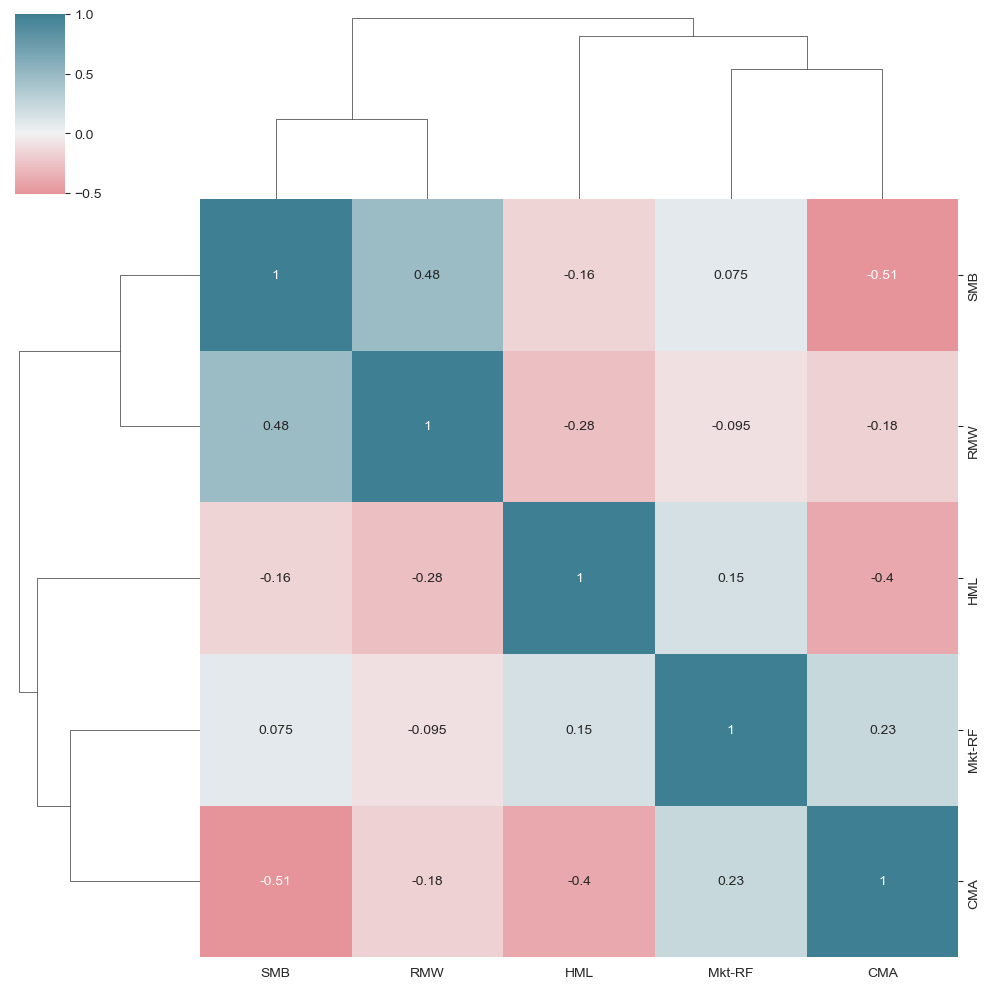

In [65]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [66]:
factors

['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

In [67]:
# Add the betas to the daily returns dataframe

historical_daily_returns = (historical_daily_returns
                              .join(betas.groupby(level='ticker')
                                         .shift())
                           )

historical_daily_returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1343141 entries, ('YRCW', Timestamp('2006-02-02 00:00:00')) to ('RAI', Timestamp('2016-12-30 00:00:00'))
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   return_1d   1343141 non-null  float64
 1   return_3d   1343141 non-null  float64
 2   return_5d   1343141 non-null  float64
 3   return_10d  1343141 non-null  float64
 4   return_21d  1343141 non-null  float64
 5   Mkt-RF      1322572 non-null  float64
 6   SMB         1322572 non-null  float64
 7   HML         1322572 non-null  float64
 8   RMW         1322572 non-null  float64
 9   CMA         1322572 non-null  float64
dtypes: float64(10)
memory usage: 140.0+ MB


In [68]:
# Use the mean to fill in missing values for the beta columns.

historical_daily_returns.loc[:, factors] = (historical_daily_returns
                                               .groupby('ticker')[factors]
                                               .apply(lambda x: x.fillna(x.mean()))
                                             )

historical_daily_returns

,,return_1d,return_3d,return_5d,return_10d,return_21d,Mkt-RF,SMB,HML,RMW,CMA
ticker,date,,,,,,,,,,
YRCW,2006-02-02,-0.01,-0.01,-0.01,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00
LVLT,2006-02-02,-0.06,-0.02,-0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00
C,2006-02-02,-0.01,-0.01,-0.01,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00
BAS,2006-02-02,0.03,0.01,0.03,0.02,0.01,0.00,0.00,0.00,-0.00,-0.00
BRK_A,2006-02-02,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...
DCT,2016-12-30,0.01,0.01,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.01
LINTA,2016-12-30,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.01
VIAS,2016-12-30,0.00,0.00,0.00,0.00,0.00,-0.01,0.07,0.01,-0.00,-0.14


## 4g. Compute the 1-day forward return

Compute the outcome variable that we will aim to predict, namely the 1-day forward returns.

From the "How to create forward returns" section on p. 97 in Machine Learning for Algorithmic Trading, 2nd. Edition:

> You can create forward returns for the current period, that is, returns that will occur in the future, using .shift() with a negative period (assuming your data is sorted in ascending order)

In [69]:
# Compute the 1-day forward return for our target.

historical_daily_returns['target_1d'] = historical_daily_returns.return_1d.shift(-1)

historical_daily_returns

,,return_1d,return_3d,return_5d,return_10d,return_21d,Mkt-RF,SMB,HML,RMW,CMA,target_1d
ticker,date,,,,,,,,,,,
YRCW,2006-02-02,-0.01,-0.01,-0.01,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.06
LVLT,2006-02-02,-0.06,-0.02,-0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,-0.01
C,2006-02-02,-0.01,-0.01,-0.01,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.03
BAS,2006-02-02,0.03,0.01,0.03,0.02,0.01,0.00,0.00,0.00,-0.00,-0.00,-0.00
BRK_A,2006-02-02,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
DCT,2016-12-30,0.01,0.01,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.01,0.00
LINTA,2016-12-30,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.01,0.00
VIAS,2016-12-30,0.00,0.00,0.00,0.00,0.00,-0.01,0.07,0.01,-0.00,-0.14,0.00


### Add the computed indicators to the final dataframe.

In [70]:
# Add the historical daily returns to the final500 dataframe.

final500 = final500.join(historical_daily_returns.swaplevel()[factors + ['target_1d']])

final500

,,open,low,high,close,volume,dollar_volume,ret,Mkt-RF,SMB,HML,RMW,CMA,target_1d
date,ticker,,,,,,,,,,,,,
2006-01-03,YRCW,"326,175.00","322,575.00","335,700.00","334,500.00","750,000.00","250,875,000,000.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,YRCW,"338,775.00","337,125.00","353,550.00","350,025.00","750,000.00","262,518,750,000.00",0.05,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,YRCW,"348,450.00","344,250.00","348,975.00","348,525.00","750,000.00","261,393,750,000.00",-0.00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,YRCW,"351,375.00","347,325.00","354,600.00","351,525.00","750,000.00","263,643,750,000.00",0.01,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-09,YRCW,"356,850.00","352,950.00","357,600.00","356,175.00",0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,RAI,55.01,54.88,55.18,55.14,"2,917,151.00","160,846,755.71",0.00,-0.00,0.00,-0.00,0.00,0.00,0.00
2016-12-27,RAI,55.14,55.04,55.39,55.29,"3,068,195.00","169,627,970.41",0.00,-0.00,0.00,-0.00,0.00,0.00,-0.02
2016-12-28,RAI,55.13,54.90,55.26,55.05,"3,705,933.00","204,010,630.72",-0.00,0.00,-0.00,-0.00,0.00,0.01,-0.03


In [71]:
# Add all the other indicator data to the final500 dataframe.

final500 = (final500.merge(bb_all.drop('close',axis=1), how='left', on=['date','ticker'])
        .merge(adx_all.drop('close',axis=1), how='left', on=['date','ticker'])
        .merge(macd_all.drop('close',axis=1), how='left', on=['date','ticker'])
        .merge(rsi_all.drop('close',axis=1), how='left', on=['date','ticker'])
        .merge(bop_all.drop('close',axis=1), how='left', on=['date','ticker'])
        .merge(mfi_all.drop('close',axis=1), how='left', on=['date','ticker'])
        .merge(ad_all.drop('close',axis=1), how='left', on=['date','ticker'])
        .merge(adosc_all.drop('close',axis=1), how='left', on=['date','ticker'])
        .merge(obv_all.drop('close',axis=1), how='left', on=['date','ticker'])
        .merge(natr_all.drop('close',axis=1), how='left', on=['date','ticker'])
     )

final500

,ticker,open,low,high,close,volume,dollar_volume,ret,Mkt-RF,SMB,...,macd,macdsignal,macdhist,rsi,bop,mfi,ad,adosc,obv,natr
date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,YRCW,"326,175.00","322,575.00","335,700.00","334,500.00","750,000.00","250,875,000,000.00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.63,NaN,"612,857.14",NaN,"750,000.00",NaN
2006-01-04,YRCW,"338,775.00","337,125.00","353,550.00","350,025.00","750,000.00","262,518,750,000.00",0.05,NaN,NaN,...,NaN,NaN,NaN,NaN,0.68,NaN,"1,040,939.33",NaN,"1,500,000.00",NaN
2006-01-05,YRCW,"348,450.00","344,250.00","348,975.00","348,525.00","750,000.00","261,393,750,000.00",-0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,0.02,NaN,"1,648,082.19",NaN,"750,000.00",NaN
2006-01-06,YRCW,"351,375.00","347,325.00","354,600.00","351,525.00","750,000.00","263,643,750,000.00",0.01,NaN,NaN,...,NaN,NaN,NaN,NaN,0.02,NaN,"1,764,061.57",NaN,"1,500,000.00",NaN
2006-01-09,YRCW,"356,850.00","352,950.00","357,600.00","356,175.00",0.00,0.00,0.01,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.15,NaN,"1,764,061.57",NaN,"1,500,000.00",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,RAI,55.01,54.88,55.18,55.14,"2,917,151.00","160,846,755.71",0.00,-0.00,0.00,...,0.74,0.75,-0.02,66.78,0.43,71.84,"289,118,864.71","5,196,469.53","631,925,433.00",1.04
2016-12-27,RAI,55.14,55.04,55.39,55.29,"3,068,195.00","169,627,970.41",0.00,-0.00,0.00,...,0.73,0.75,-0.02,68.06,0.42,70.48,"290,312,051.65","5,339,682.69","634,993,628.00",1.01
2016-12-28,RAI,55.13,54.90,55.26,55.05,"3,705,933.00","204,010,630.72",-0.00,0.00,-0.00,...,0.70,0.74,-0.04,63.83,-0.22,62.80,"289,694,396.15","4,716,317.44","631,287,695.00",0.99


In [72]:
final500

,ticker,open,low,high,close,volume,dollar_volume,ret,Mkt-RF,SMB,...,macd,macdsignal,macdhist,rsi,bop,mfi,ad,adosc,obv,natr
date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,YRCW,"326,175.00","322,575.00","335,700.00","334,500.00","750,000.00","250,875,000,000.00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.63,NaN,"612,857.14",NaN,"750,000.00",NaN
2006-01-04,YRCW,"338,775.00","337,125.00","353,550.00","350,025.00","750,000.00","262,518,750,000.00",0.05,NaN,NaN,...,NaN,NaN,NaN,NaN,0.68,NaN,"1,040,939.33",NaN,"1,500,000.00",NaN
2006-01-05,YRCW,"348,450.00","344,250.00","348,975.00","348,525.00","750,000.00","261,393,750,000.00",-0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,0.02,NaN,"1,648,082.19",NaN,"750,000.00",NaN
2006-01-06,YRCW,"351,375.00","347,325.00","354,600.00","351,525.00","750,000.00","263,643,750,000.00",0.01,NaN,NaN,...,NaN,NaN,NaN,NaN,0.02,NaN,"1,764,061.57",NaN,"1,500,000.00",NaN
2006-01-09,YRCW,"356,850.00","352,950.00","357,600.00","356,175.00",0.00,0.00,0.01,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.15,NaN,"1,764,061.57",NaN,"1,500,000.00",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,RAI,55.01,54.88,55.18,55.14,"2,917,151.00","160,846,755.71",0.00,-0.00,0.00,...,0.74,0.75,-0.02,66.78,0.43,71.84,"289,118,864.71","5,196,469.53","631,925,433.00",1.04
2016-12-27,RAI,55.14,55.04,55.39,55.29,"3,068,195.00","169,627,970.41",0.00,-0.00,0.00,...,0.73,0.75,-0.02,68.06,0.42,70.48,"290,312,051.65","5,339,682.69","634,993,628.00",1.01
2016-12-28,RAI,55.13,54.90,55.26,55.05,"3,705,933.00","204,010,630.72",-0.00,0.00,-0.00,...,0.70,0.74,-0.04,63.83,-0.22,62.80,"289,694,396.15","4,716,317.44","631,287,695.00",0.99


## Persist results

In [73]:
with pd.HDFStore(DATA_STORE) as store:
    store['data/top500'] = final500
    
    print(f"keys: {store.keys()}")
    print(f"\ninfo: {store.info()}")

keys: ['/us_stocks', '/data/top500']

info: <class 'pandas.io.pytables.HDFStore'>
File path: ../data/data.h5
/data/top500            frame        (shape->[1343376,28])
/us_stocks              frame        (shape->[11343920,5])
